In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from torch.utils.data import TensorDataset, DataLoader
import math
import copy

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA available: True


In [34]:
class ChebySigmoidActivation(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def get_n_value(self):
        return self.n

    def forward(self, x):
        sigmoid_val = torch.sigmoid(x)
        tanh_beta_val = torch.tanh(self.beta * x)
        safe_tanh_beta_val = torch.clamp(tanh_beta_val, -1 + 1e-6, 1 - 1e-6)
        out = sigmoid_val + self.alpha * torch.cos(self.n * torch.acos(safe_tanh_beta_val)) * sigmoid_val * (1 - sigmoid_val)
        return out

class ChebyTanhActivation(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n

    def get_n_value(self):
        return self.n

    def forward(self, x):
        tanh_beta_val = torch.tanh(self.beta * x)
        tanh_val = torch.tanh(x)
        sech_val = (1 / torch.cosh(x)) ** 2
        safe_tanh_beta_val = torch.clamp(tanh_beta_val, -1 + 1e-6, 1 - 1e-6)
        out = tanh_val + self.alpha * torch.cos(self.n * torch.acos(safe_tanh_beta_val)) * sech_val
        return out

In [35]:
class BaselineMultivariateLSTM(nn.Module):
    """
    Plain LSTM baseline:
    - same input/output interface as MultivariateLSTM
    - uses standard nn.LSTM (tanh/sigmoid)
    """
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, output_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)
            if module.bias is not None:
                init.constant_(module.bias, 0)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    init.xavier_uniform_(param)
                elif 'bias' in name:
                    init.constant_(param, 0)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]          # last timestep
        last_output = self.dropout(last_output)
        preds = self.linear(last_output)          # [batch, output_size]
        return preds

    def get_n_values(self):
        # for compatibility with existing code that calls model.get_n_values()
        return {'sigmoid_n': 0.0, 'tanh_n': 0.0}


In [36]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM Parameters
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.zeros(4 * hidden_size))


        # Custom Activation Functions
        self.sigmoid_activation = ChebySigmoidActivation(alpha=alpha, beta=beta, n=n)
        self.tanh_activation = ChebyTanhActivation(alpha=alpha, beta=beta, n=n)

        # Add batch normalization
        #self.bn_ih = nn.BatchNorm1d(4 * hidden_size)
        #self.bn_hh = nn.BatchNorm1d(4 * hidden_size)
        #self.bn_c = nn.BatchNorm1d(hidden_size)

    def forward(self, input, hx):
        h_prev, c_prev = hx
        batch_size = input.size(0)

        # Compute gates with batch normalization
        ih = F.linear(input, self.weight_ih, self.bias_ih)
        hh = F.linear(h_prev, self.weight_hh, self.bias_hh)

        gates = ih + hh

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        # Apply Chebyshev activations to gates
        forgetgate = self.sigmoid_activation(forgetgate)
        ingate = self.sigmoid_activation(ingate)
        cellgate_candidate = self.tanh_activation(cellgate)
        outgate = self.sigmoid_activation(outgate)

        # Update cell state
        c_next = forgetgate * c_prev + ingate * cellgate_candidate

        # Apply batch norm to cell state if batch size > 1
        #if batch_size > 1:
        #    c_next = self.bn_c(c_next)

        # Update hidden state
        h_next = outgate * self.tanh_activation(c_next)

        return h_next, (h_next, c_next)

    def get_n_values(self):
        return {
            'sigmoid_n': self.sigmoid_activation.get_n_value(),
            'tanh_n': self.tanh_activation.get_n_value()
        }

In [37]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.cell = CustomLSTMCell(input_size, hidden_size, alpha=alpha, beta=beta, n=n)
        self.hidden_size = hidden_size

    def forward(self, inputs, hx=None):
        # Handle batch_first=True for convenience
        # Expected input shape: [batch_size, seq_len, features]
        inputs = inputs.transpose(0, 1)  # Convert to [seq_len, batch_size, features]

        if hx is None:
            batch_size = inputs.size(1)
            h_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            c_0 = torch.zeros(batch_size, self.cell.hidden_size, device=inputs.device)
            hx = (h_0, c_0)

        h, c = hx
        outputs = []

        for t in range(inputs.size(0)):
            h, (h, c) = self.cell(inputs[t], (h, c))
            outputs.append(h)

        outputs = torch.stack(outputs)
        # Convert back to batch_first format
        outputs = outputs.transpose(0, 1)
        return outputs, (h, c)

    def get_n_values(self):
        return self.cell.get_n_values()

In [38]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.lstm = CustomLSTM(input_size, hidden_size, alpha=alpha, beta=beta, n=n)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, output_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)
            if module.bias is not None:
                init.constant_(module.bias, 0)
        elif isinstance(module, CustomLSTMCell):
            init.xavier_uniform_(module.weight_ih)
            init.xavier_uniform_(module.weight_hh)
            init.constant_(module.bias_ih, 0)
            init.constant_(module.bias_hh, 0)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        predictions = self.linear(last_output)
        return predictions

    def get_n_values(self):
        return self.lstm.get_n_values()

In [39]:
def create_multivariate_sequences(data, seq_length, feature_column_idx=None, target_column_idx=None):
    """
    Create input/output sequences from multivariate time series data

    Parameters:
    - data: numpy array of shape (samples, features)
    - seq_length: number of time steps to look back
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - X: input sequences
    - y: target values
    """
    xs, ys = [], []

    # Convert feature_column_idx to list if it's a single index
    if feature_column_idx is not None and not isinstance(feature_column_idx, list):
        feature_column_idx = [feature_column_idx]

    for i in range(len(data) - seq_length):
        # Input sequence
        if feature_column_idx is not None:
            # Use only specified feature columns
            x = data[i:i+seq_length, feature_column_idx]
        else:
            # Use all features
            x = data[i:i+seq_length]

        # Output value
        if target_column_idx is not None:
            y = data[i+seq_length, target_column_idx:target_column_idx+1]
        else:
            # Default to predicting all variables
            y = data[i+seq_length]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


def prepare_multivariate_data(data, seq_length=20, train_ratio=0.8, batch_size=32,
                             feature_column_idx=None, target_column_idx=None):
    """
    Prepare multivariate time series data for LSTM training

    Parameters:
    - data: pandas DataFrame or numpy array with multiple columns
    - seq_length: number of time steps to look back
    - train_ratio: proportion of data to use for training
    - batch_size: batch size for training
    - feature_column_idx: index or list of indices of features to use for prediction
    - target_column_idx: which feature to predict

    Returns:
    - Dictionary with data loaders, scalers, and other information
    """
    # Convert to numpy array if needed
    if isinstance(data, pd.DataFrame):
        column_names = data.columns
        data = data.values
    else:
        column_names = [f"Feature_{i}" for i in range(data.shape[1])]

    # Store original shape
    n_samples, n_features = data.shape
    print(f"Data shape: {n_samples} samples, {n_features} features")

    # Determine output size
    output_size = 1 if target_column_idx is not None else n_features

    # Determine input size
    if feature_column_idx is not None:
        if isinstance(feature_column_idx, list):
            input_size = len(feature_column_idx)
        else:
            input_size = 1
    else:
        input_size = n_features

    print(f"Using {input_size} input feature(s) to predict {output_size} output(s)")

    # Scale the data - fit scaler on training portion to avoid data leakage
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)

    # Scale all data
    data_scaled = scaler.transform(data)
    if np.isnan(data_scaled).any():
        print("NaNs found in the data AFTER scaling!")
    # This indicates an issue with the original data or the scaler

    # Create sequences
    X, y = create_multivariate_sequences(data_scaled, seq_length, feature_column_idx, target_column_idx)

    # Split into train and test sets
    X_train, X_test = X[:train_size-seq_length], X[train_size-seq_length:]
    y_train, y_test = y[:train_size-seq_length], y[train_size-seq_length:]

    print(f"Created {len(X)} sequences with length {seq_length}")
    print(f"Training set: {len(X_train)} sequences, Test set: {len(X_test)} sequences")
    print(f"Input shape: {X.shape}, Output shape: {y.shape}")

    # Convert to PyTorch tensors and move to device
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_test = torch.FloatTensor(y_test).to(device)

    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'test_loader': test_loader,
        'scaler': scaler,
        'data': data,
        'scaled_data': data_scaled,
        'train_size': train_size,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'seq_length': seq_length,
        'column_names': column_names,
        'output_size': output_size,
        'input_size': input_size,
        'feature_column_idx': feature_column_idx,
        'target_column_idx': target_column_idx
    }

In [40]:
def autoregressive_rollout(model, data_dict, split="test", horizon=None, num_seeds=1):
    model.eval()
    scaler = data_dict['scaler']
    data = data_dict['data']
    if isinstance(data, pd.DataFrame):
        data = data.values
    seq_length = data_dict['seq_length']
    train_size = data_dict['train_size']
    target_idx = data_dict['target_column_idx']

    if target_idx is not None:
        raise ValueError("Autoregressive rollout here assumes target_column_idx=None (predict all features).")

    n = len(data)
    if split == "train":
        start_min = 0
        end_max = train_size
    elif split == "test":
        start_min = train_size - seq_length
        end_max = n
    else:
        raise ValueError("split must be 'train' or 'test'")

    if horizon is None:
        horizon = end_max - (start_min + seq_length)
    horizon = max(1, horizon)

    max_start = end_max - seq_length - horizon
    if max_start <= start_min:
        seeds = [start_min]
    else:
        seeds = np.linspace(start_min, max_start, num_seeds, dtype=int)

    results = []
    with torch.no_grad():
        for s in seeds:
            init_true = data[s:s+seq_length]
            init_scaled = scaler.transform(init_true)
            hist = init_scaled.copy()
            preds_scaled = []
            for t in range(horizon):
                x = torch.from_numpy(hist[-seq_length:]).float().unsqueeze(0).to(device)
                y = model(x).cpu().numpy().reshape(-1)
                preds_scaled.append(y)
                hist = np.vstack([hist, y])
            preds_scaled = np.array(preds_scaled)
            preds = scaler.inverse_transform(preds_scaled)
            true = data[s+seq_length:s+seq_length+horizon]
            results.append((true, preds, s))
    return results


In [41]:
def train_model(model, train_loader, test_loader, epochs=100, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)


    train_losses = []
    test_losses = []
    sigmoid_n_values = []
    tanh_n_values = []

    print(f"Starting training for {epochs} epochs on {device}...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            # Optional: gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Get current n values
        n_values = model.get_n_values()
        sigmoid_n = n_values['sigmoid_n']
        tanh_n = n_values['tanh_n']
        sigmoid_n_values.append(sigmoid_n)
        tanh_n_values.append(tanh_n)

        # Evaluate on test data
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                y_pred = model(X_test)
                test_loss += criterion(y_pred, y_test).item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        # Update learning rate based on test loss (WRONG!!)
        #scheduler.step(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Sigmoid n: {sigmoid_n:.4f}, Tanh n: {tanh_n:.4f}')

    print("Training completed.")
    return train_losses, test_losses, sigmoid_n_values, tanh_n_values


In [42]:
def predict_all_data(model, data_dict):
    """
    Make predictions for both training and testing data
    """
    model.eval()

    # Predict on training data
    with torch.no_grad():
        train_predictions_scaled = model(data_dict['X_train']).cpu().numpy()
        test_predictions_scaled = model(data_dict['X_test']).cpu().numpy()

    # Get actual values
    train_actual_scaled = data_dict['y_train'].cpu().numpy()
    test_actual_scaled = data_dict['y_test'].cpu().numpy()

    # Prepare containers for inverse-transformed data
    train_predictions = np.zeros_like(train_predictions_scaled)
    test_predictions = np.zeros_like(test_predictions_scaled)
    train_actual = np.zeros_like(train_actual_scaled)
    test_actual = np.zeros_like(test_actual_scaled)

    # Inverse transform
    scaler = data_dict['scaler']

    # If we're predicting a single target variable
    if data_dict['target_column_idx'] is not None:
        target_idx = data_dict['target_column_idx']

        # Prepare dummy arrays for inverse transform
        dummy_train_pred = np.zeros((train_predictions_scaled.shape[0], scaler.scale_.shape[0]))
        dummy_test_pred = np.zeros((test_predictions_scaled.shape[0], scaler.scale_.shape[0]))
        dummy_train_actual = np.zeros((train_actual_scaled.shape[0], scaler.scale_.shape[0]))
        dummy_test_actual = np.zeros((test_actual_scaled.shape[0], scaler.scale_.shape[0]))

        # Fill dummy arrays with the predicted values
        dummy_train_pred[:, target_idx:target_idx+1] = train_predictions_scaled
        dummy_test_pred[:, target_idx:target_idx+1] = test_predictions_scaled
        dummy_train_actual[:, target_idx:target_idx+1] = train_actual_scaled
        dummy_test_actual[:, target_idx:target_idx+1] = test_actual_scaled

        # Inverse transform
        train_pred_full = scaler.inverse_transform(dummy_train_pred)
        test_pred_full = scaler.inverse_transform(dummy_test_pred)
        train_actual_full = scaler.inverse_transform(dummy_train_actual)
        test_actual_full = scaler.inverse_transform(dummy_test_actual)

        # Extract target column
        train_predictions = train_pred_full[:, target_idx:target_idx+1]
        test_predictions = test_pred_full[:, target_idx:target_idx+1]
        train_actual = train_actual_full[:, target_idx:target_idx+1]
        test_actual = test_actual_full[:, target_idx:target_idx+1]
    else:
        # If predicting all variables, directly inverse transform
        train_predictions = scaler.inverse_transform(train_predictions_scaled)
        test_predictions = scaler.inverse_transform(test_predictions_scaled)
        train_actual = scaler.inverse_transform(train_actual_scaled)
        test_actual = scaler.inverse_transform(test_actual_scaled)

    return {
        'train_predictions': train_predictions,
        'train_actual': train_actual,
        'test_predictions': test_predictions,
        'test_actual': test_actual,
        'train_predictions_scaled': train_predictions_scaled,
        'train_actual_scaled': train_actual_scaled,
        'test_predictions_scaled': test_predictions_scaled,
        'test_actual_scaled': test_actual_scaled
    }


In [43]:
def visualize_autoregressive(model, data_dict, split="test", horizon=500, num_seeds=1, title_prefix=""):
    results = autoregressive_rollout(model, data_dict, split=split, horizon=horizon, num_seeds=num_seeds)
    data = data_dict['data']
    if isinstance(data, pd.DataFrame):
        cols = list(data.columns)
    else:
        cols = [f"Feature_{i}" for i in range(data.shape[1])]

    for idx, (true, preds, start) in enumerate(results):
        steps = true.shape[0]
        t = np.arange(steps)

        plt.figure(figsize=(14, 6))
        for j in range(true.shape[1]):
            plt.subplot(true.shape[1], 1, j+1)
            plt.plot(t, true[:, j], label=f"True {cols[j]}")
            plt.plot(t, preds[:, j], "--", label=f"Pred {cols[j]}")
            if j == 0:
                plt.title(f"{title_prefix}{split.capitalize()} AR rollout (seed {idx}, start {start})")
            if j == true.shape[1] - 1:
                plt.xlabel("Step")
            plt.ylabel(cols[j])
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()


In [44]:
def predict_and_visualize_multivariate(model, data_dict, title='Multivariate Time Series Forecasting'):
    """
    Visualization for multivariate time series predictions
    """
    # Get predictions
    predictions = predict_all_data(model, data_dict)

    # Determine if we're predicting single or multiple targets
    is_single_target = data_dict['target_column_idx'] is not None
    target_idx = data_dict['target_column_idx'] if is_single_target else None

    # Get target name(s)
    if is_single_target:
        target_name = data_dict['column_names'][target_idx]
        target_names = [target_name]
    else:
        target_names = data_dict['column_names']

    # Calculate RMSE for each target
    train_rmse_values = []
    test_rmse_values = []
    train_rmse_scaled_values = []
    test_rmse_scaled_values = []

    # Create sequence indices for plotting
    seq_length = data_dict['seq_length']
    train_indices = np.arange(seq_length, seq_length + predictions['train_actual'].shape[0])
    test_indices = np.arange(
        seq_length + predictions['train_actual'].shape[0],
        seq_length + predictions['train_actual'].shape[0] + predictions['test_actual'].shape[0]
    )

    # Process each target variable
    for i in range(len(target_names)):
        if is_single_target:
            # If predicting single target, data is already shaped correctly
            train_actual_i = predictions['train_actual']
            train_pred_i = predictions['train_predictions']
            test_actual_i = predictions['test_actual']
            test_pred_i = predictions['test_predictions']
            train_actual_scaled_i = predictions['train_actual_scaled']
            train_pred_scaled_i = predictions['train_predictions_scaled']
            test_actual_scaled_i = predictions['test_actual_scaled']
            test_pred_scaled_i = predictions['test_predictions_scaled']
        else:
            # If predicting multiple targets, extract the i-th target
            train_actual_i = predictions['train_actual'][:, i:i+1]
            train_pred_i = predictions['train_predictions'][:, i:i+1]
            test_actual_i = predictions['test_actual'][:, i:i+1]
            test_pred_i = predictions['test_predictions'][:, i:i+1]
            train_actual_scaled_i = predictions['train_actual_scaled'][:, i:i+1]
            train_pred_scaled_i = predictions['train_predictions_scaled'][:, i:i+1]
            test_actual_scaled_i = predictions['test_actual_scaled'][:, i:i+1]
            test_pred_scaled_i = predictions['test_predictions_scaled'][:, i:i+1]

        # Calculate RMSE
        train_rmse = sqrt(mean_squared_error(train_actual_i, train_pred_i))
        test_rmse = sqrt(mean_squared_error(test_actual_i, test_pred_i))
        train_rmse_scaled = sqrt(mean_squared_error(train_actual_scaled_i, train_pred_scaled_i))
        test_rmse_scaled = sqrt(mean_squared_error(test_actual_scaled_i, test_pred_scaled_i))

        train_rmse_values.append(train_rmse)
        test_rmse_values.append(test_rmse)
        train_rmse_scaled_values.append(train_rmse_scaled)
        test_rmse_scaled_values.append(test_rmse_scaled)

        # Only create plots for single target or if explicitly predicting all variables with 3 or fewer features
        if is_single_target or (len(target_names) <= 3):
            # Plot complete time series with original data
            plt.figure(figsize=(15, 8))


            # Plot test predictions (zoomed in)
            plt.figure(figsize=(15, 6))
            plt.plot(test_actual_i, label=f'Test Actual - {target_names[i]}', color='darkblue')
            plt.plot(test_pred_i, label=f'Test Predictions - {target_names[i]}', color='red')
            plt.title(f'Test Data Predictions - {target_names[i]} - RMSE: {test_rmse:.4f}')
            plt.xlabel('Sample Index')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Print overall metrics summary
    for i, target_name in enumerate(target_names):
        print(f"\nMetrics for {target_name}:")
        print(f"Training RMSE: {train_rmse_values[i]:.4f}")
        print(f"Test RMSE: {test_rmse_values[i]:.4f}")
        print(f"Training RMSE (Scaled): {train_rmse_scaled_values[i]:.4f}")
        print(f"Test RMSE (Scaled): {test_rmse_scaled_values[i]:.4f}")

    # If there are multiple targets, calculate average metrics
    if len(target_names) > 1:
        print("\nAverage Metrics Across All Targets:")
        print(f"Avg Training RMSE: {np.mean(train_rmse_values):.4f}")
        print(f"Avg Test RMSE: {np.mean(test_rmse_values):.4f}")

    # Print final n values
    n_values = model.get_n_values()
    print(f"\nFinal Sigmoid n value: {n_values['sigmoid_n']:.4f}")
    print(f"Final Tanh n value: {n_values['tanh_n']:.4f}")

    return {
        'train_rmse': train_rmse_values,
        'test_rmse': test_rmse_values,
        'train_rmse_scaled': train_rmse_scaled_values,
        'test_rmse_scaled': test_rmse_scaled_values,
        'predictions': predictions,
        'n_values': n_values
    }


In [45]:
def load_multivariate_from_csv(csv_path, feature_columns=None, date_column=None):
    """
    Load multivariate time series data from a CSV file.

    Parameters:
    - csv_path: path to the CSV file
    - feature_columns: list of column names to use as features (None = use all numeric columns)
    - date_column: name of the date column (optional)

    Returns:
    - DataFrame containing the selected features
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    print(f"CSV loaded successfully. Columns: {', '.join(df.columns)}")

    # Convert date column to datetime if specified
    if date_column is not None and date_column in df.columns:
        df[date_column] = pd.to_datetime(df[date_column])
        df = df.sort_values(by=date_column)
        print(f"Data sorted by {date_column}")

    # Select features
    if feature_columns is None:
        # Use all numeric columns if none specified
        feature_columns = df.select_dtypes(include=['number']).columns.tolist()
        # Remove date column if it was included
        if date_column in feature_columns:
            feature_columns.remove(date_column)
    else:
        # Verify all requested columns exist
        missing_cols = [col for col in feature_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Columns not found in CSV: {missing_cols}")

    # Extract features
    features_df = df[feature_columns].copy()
    print(f"Selected {len(feature_columns)} features: {', '.join(feature_columns)}")

    # Check for missing values
    missing_values = features_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Found {missing_values} missing values. Filling with forward fill then backward fill.")
        features_df = features_df.fillna(method='ffill').fillna(method='bfill')

        # Check if there are still missing values
        remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
             # Check if there are still missing values
            remaining_missing = features_df.isnull().sum().sum()
        if remaining_missing > 0:
            print(f"Warning: {remaining_missing} missing values remain after filling.")
            print("Filling remaining missing values with column means.")
            features_df = features_df.fillna(features_df.mean())

    return features_df




In [46]:
def train_from_csv(csv_path,
                   feature_column=None,
                   target_column=None,
                   date_column=None,
                   seq_length=20,
                   hidden_size=50,
                   epochs=100,
                   batch_size=32,
                   learning_rate=0.0001,
                   alpha=1.0,
                   beta=1.0,
                   n=1.0,
                   use_cheby=True):
    """
    Train either the Chebyshev-LSTM (use_cheby=True) or a baseline LSTM (use_cheby=False)
    on lorenz/rossler-style data with columns x,y,z.

    - Uses x,y,z as inputs and predicts x,y,z (multivariate next-step).
    - Computes 1-step RMSEs (teacher forcing) for inspection.
    - Computes autoregressive Test RMSE over 500-step closed-loop rollouts (ar_test_rmse).
    """

    print(f"Loading data from {csv_path}...")

    # Load full data (handles date_column if provided)
    all_data = load_multivariate_from_csv(
        csv_path,
        feature_columns=None,
        date_column=date_column
    )

    # Require x,y,z
    if not set(['x', 'y', 'z']).issubset(all_data.columns):
        raise ValueError("Expected columns 'x', 'y', 'z' in CSV for this setup.")

    # Use only x,y,z as features for this experiment
    data = all_data[['x', 'y', 'z']]
    print(f"Data shape: {data.shape[0]} samples, {data.shape[1]} features")

    # We predict all 3 vars; no special indices needed
    feature_column_idx = None
    target_column_idx = None

    # Prepare scaled sequences and loaders
    data_dict = prepare_multivariate_data(
        data,
        seq_length=seq_length,
        train_ratio=0.8,
        batch_size=batch_size,
        feature_column_idx=feature_column_idx,
        target_column_idx=target_column_idx
    )

    # Extra info needed by AR helpers
    data_dict['data'] = data
    data_dict['seq_length'] = seq_length
    data_dict['train_size'] = int(0.8 * len(data))
    data_dict['target_column_idx'] = target_column_idx

    input_size = data_dict['input_size']
    output_size = data_dict['output_size']

    print(f"Using {input_size} input feature(s) to predict {output_size} output(s)")
    # Choose model: Cheby or baseline
    if use_cheby:
        model = MultivariateLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            alpha=alpha,
            beta=beta,
            n=n
        ).to(device)
        print("Model: Chebyshev LSTM")
    else:
        model = BaselineMultivariateLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size
        ).to(device)
        print("Model: Baseline LSTM")

    # Train
    train_losses, test_losses, sigmoid_n_values, tanh_n_values = train_model(
        model,
        data_dict['train_loader'],
        data_dict['test_loader'],
        epochs=epochs,
        learning_rate=learning_rate
    )

    print("\nEvaluating model and generating predictions...")

    # Title is generic since we always use all features
    title = 'Multivariate Time Series Forecasting (x,y,z)'

    # One-step (teacher-forced) metrics & plots
    results = predict_and_visualize_multivariate(
        model,
        data_dict,
        title=title
    )

    # Autoregressive visualizations (closed-loop)
    visualize_autoregressive(
        model,
        data_dict,
        split="train",
        horizon=500,
        num_seeds=1,
        title_prefix="AR Train - "
    )
    visualize_autoregressive(
        model,
        data_dict,
        split="test",
        horizon=500,
        num_seeds=1,
        title_prefix="AR Test - "
    )

    # Autoregressive Test RMSE over 500 steps, averaged over a few seeds
    ar_rollouts = autoregressive_rollout(
        model,
        data_dict,
        split="test",
        horizon=500,
        num_seeds=3
    )

    if ar_rollouts:
        mses = []
        for (true, preds, _) in ar_rollouts:
            T = min(len(true), len(preds))
            if T <= 1:
                continue
            # MSE over all dims and all steps in this rollout
            mse = mean_squared_error(true[:T].reshape(-1, true.shape[1]),
                                     preds[:T].reshape(-1, preds.shape[1]))
            mses.append(mse)

        if mses:
            ar_test_rmse = float(np.sqrt(np.mean(mses)))
            results["ar_test_rmse"] = ar_test_rmse
            print(f"Autoregressive Test RMSE (avg over seeds, 500 steps): {ar_test_rmse:.4f}")
        else:
            results["ar_test_rmse"] = None
            print("Autoregressive RMSE could not be computed (no valid rollouts).")
    else:
        results["ar_test_rmse"] = None
        print("No AR rollouts produced; ar_test_rmse set to None.")

    # n-values (Cheby) or dummy zeros (baseline)
    n_values = model.get_n_values()
    if use_cheby:
        print(f"Final Sigmoid n value: {n_values['sigmoid_n']:.4f}")
        print(f"Final Tanh n value:   {n_values['tanh_n']:.4f}")
    else:
        print("Baseline LSTM used (Chebyshev n-values not applicable).")

    # 1-step summary (still useful for sanity, but NSGA won't use it)
    if "train_rmse" in results and "test_rmse" in results:
        print(f"Training RMSE (1-step, avg over dims): {np.mean(results['train_rmse']):.4f}")
        print(f"Test RMSE (1-step, avg over dims):     {np.mean(results['test_rmse']):.4f}")

    return model, results, (train_losses, test_losses, sigmoid_n_values, tanh_n_values)


In [47]:
def compute_lyapunov_multivariate(initial_sequence, model, steps=1000, delta=1e-5):
    """
    Estimate largest Lyapunov exponent (LLE) for multivariate sequence using a trained model.
    Uses Wolf-style renormalization to keep perturbation stable.

    Args:
        initial_sequence: numpy array, shape (seq_len, num_features), ground truth seed sequence
        model: trained PyTorch model
        steps: number of forward steps
        delta: small perturbation size

    Returns:
        lyap: estimated LLE (slope of divergence curve)
        t_vals: array of time steps
        divergences: log divergence values
    """
    seq_len, num_features = initial_sequence.shape
    device = next(model.parameters()).device

    # Base trajectory (1, seq_len, num_features)
    x0 = initial_sequence.reshape(1, seq_len, num_features).astype(np.float32)

    # Perturbed trajectory
    perturb = np.random.randn(*x0.shape)
    perturb /= np.linalg.norm(perturb)
    perturb *= delta
    x1 = x0 + perturb

    d0 = np.linalg.norm(perturb)
    divergences = []

    for t in range(steps):
        with torch.no_grad():
            x0_tensor = torch.tensor(x0, dtype=torch.float32, device=device)
            x1_tensor = torch.tensor(x1, dtype=torch.float32, device=device)

            # Model predicts the next state vector (shape: (1, num_features))
            y0 = model(x0_tensor).cpu().numpy().reshape(1, num_features)
            y1 = model(x1_tensor).cpu().numpy().reshape(1, num_features)

        diff = y1 - y0
        d = np.linalg.norm(diff)

        if d > 1e-12:
            divergences.append(np.log(d / d0))
            # Renormalize perturbed trajectory along divergence direction
            direction = diff / d
            y1 = y0 + d0 * direction
        else:
            # If collapsed, kick it slightly in a random direction
            rand_dir = np.random.randn(*y0.shape)
            rand_dir /= np.linalg.norm(rand_dir)
            y1 = y0 + d0 * rand_dir

        # Roll the window forward: drop first, append new prediction
        x0 = np.roll(x0, -1, axis=1)
        x0[0, -1, :] = y0
        x1 = np.roll(x1, -1, axis=1)
        x1[0, -1, :] = y1

    divergences = np.array(divergences)
    t_vals = np.arange(len(divergences))

    if len(divergences) > 1:
        coeffs = np.polyfit(t_vals, divergences, 1)
        lyap = coeffs[0]
    else:
        lyap = float("nan")

    return lyap*100, t_vals, divergences








Below Model uses  {'alpha': 0.4, 'beta': 0.6, 'n': 1, 'seq_length': 60}
Loading data from lorenz5.csv...
CSV loaded successfully. Columns: timestep, x, y, z
Selected 4 features: timestep, x, y, z
Data shape: 20000 samples, 3 features
Data shape: 20000 samples, 3 features
Using 3 input feature(s) to predict 3 output(s)
Created 19940 sequences with length 60
Training set: 15940 sequences, Test set: 4000 sequences
Input shape: (19940, 60, 3), Output shape: (19940, 3)
Using 3 input feature(s) to predict 3 output(s)
Model: Baseline LSTM
Starting training for 5 epochs on cuda...
Epoch 1/5, Train Loss: 0.0488, Test Loss: 0.0087, Sigmoid n: 0.0000, Tanh n: 0.0000
Epoch 2/5, Train Loss: 0.0055, Test Loss: 0.0009, Sigmoid n: 0.0000, Tanh n: 0.0000
Epoch 3/5, Train Loss: 0.0031, Test Loss: 0.0003, Sigmoid n: 0.0000, Tanh n: 0.0000
Epoch 4/5, Train Loss: 0.0027, Test Loss: 0.0002, Sigmoid n: 0.0000, Tanh n: 0.0000
Epoch 5/5, Train Loss: 0.0024, Test Loss: 0.0001, Sigmoid n: 0.0000, Tanh n: 0

<Figure size 1500x800 with 0 Axes>

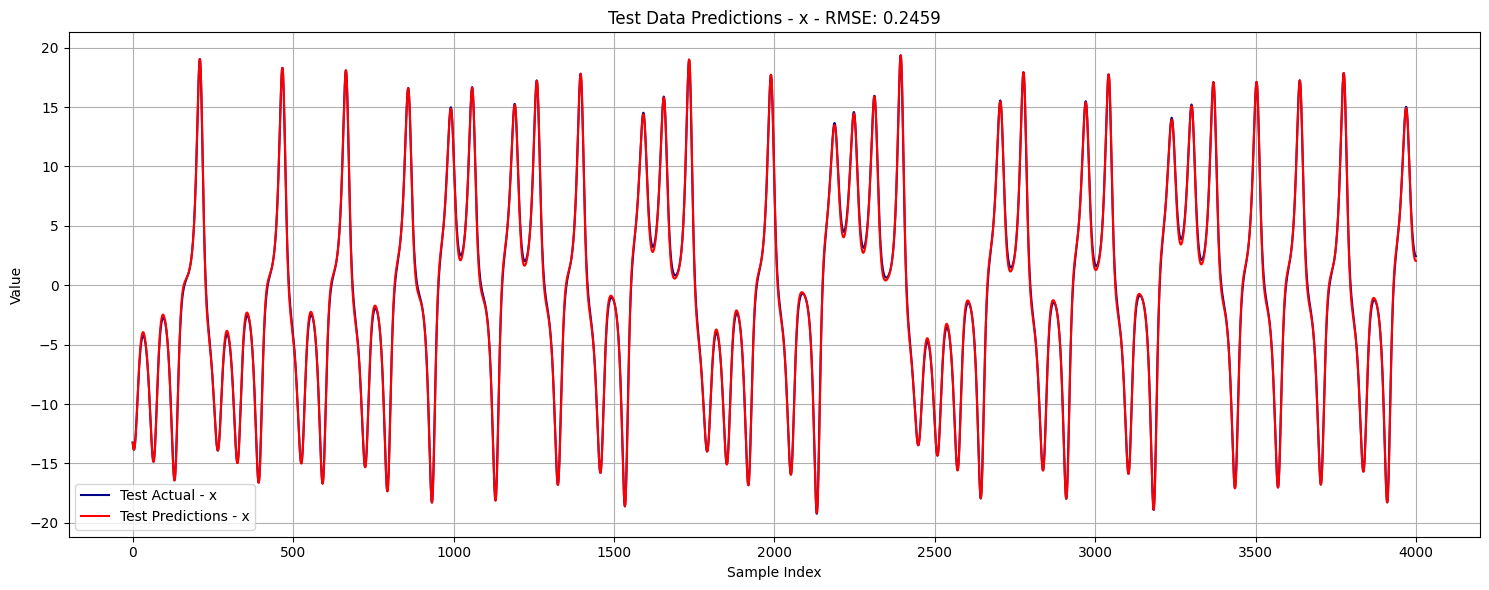

<Figure size 1500x800 with 0 Axes>

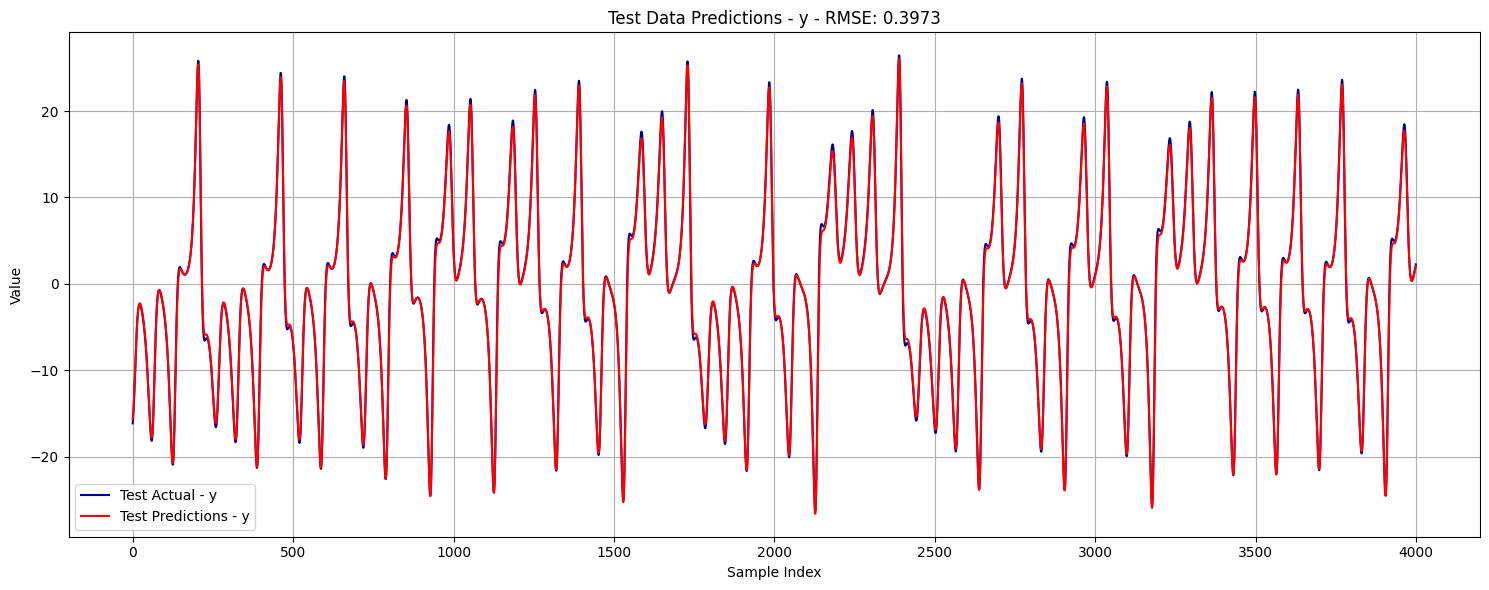

<Figure size 1500x800 with 0 Axes>

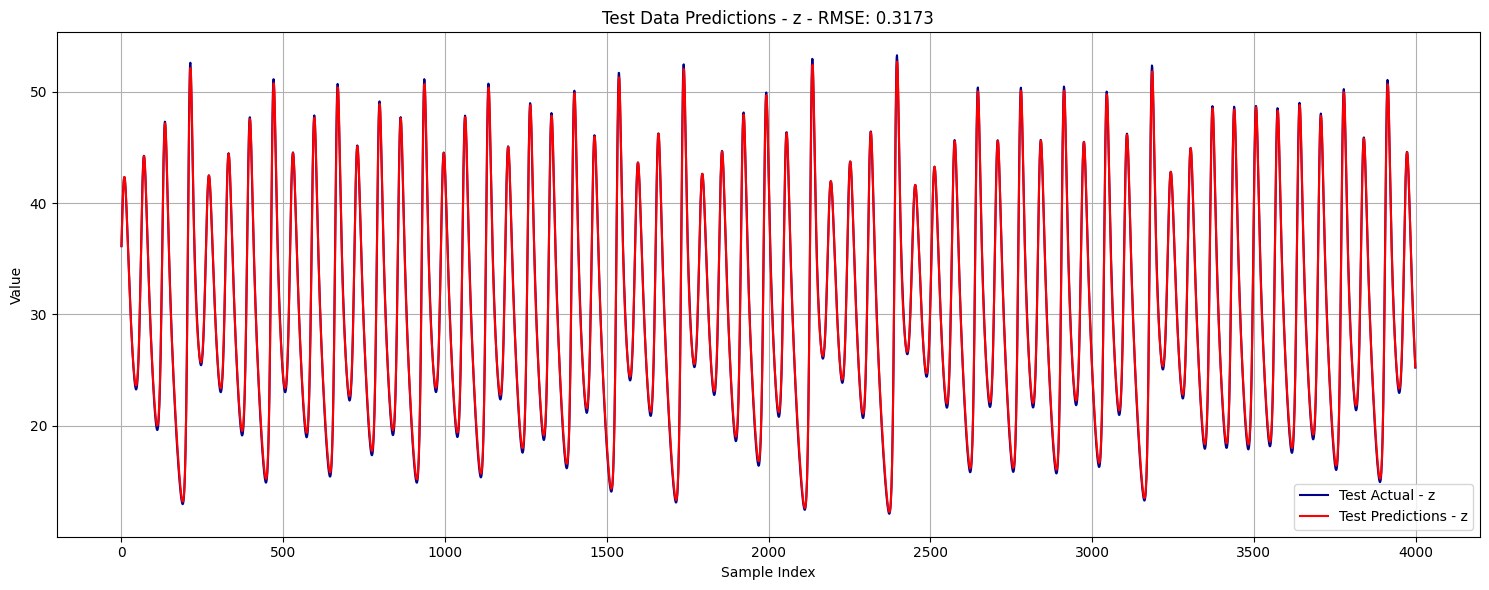


Metrics for x:
Training RMSE: 0.2584
Test RMSE: 0.2459
Training RMSE (Scaled): 0.0118
Test RMSE (Scaled): 0.0112

Metrics for y:
Training RMSE: 0.4731
Test RMSE: 0.3973
Training RMSE (Scaled): 0.0149
Test RMSE (Scaled): 0.0125

Metrics for z:
Training RMSE: 0.3084
Test RMSE: 0.3173
Training RMSE (Scaled): 0.0102
Test RMSE (Scaled): 0.0105

Average Metrics Across All Targets:
Avg Training RMSE: 0.3466
Avg Test RMSE: 0.3202

Final Sigmoid n value: 0.0000
Final Tanh n value: 0.0000


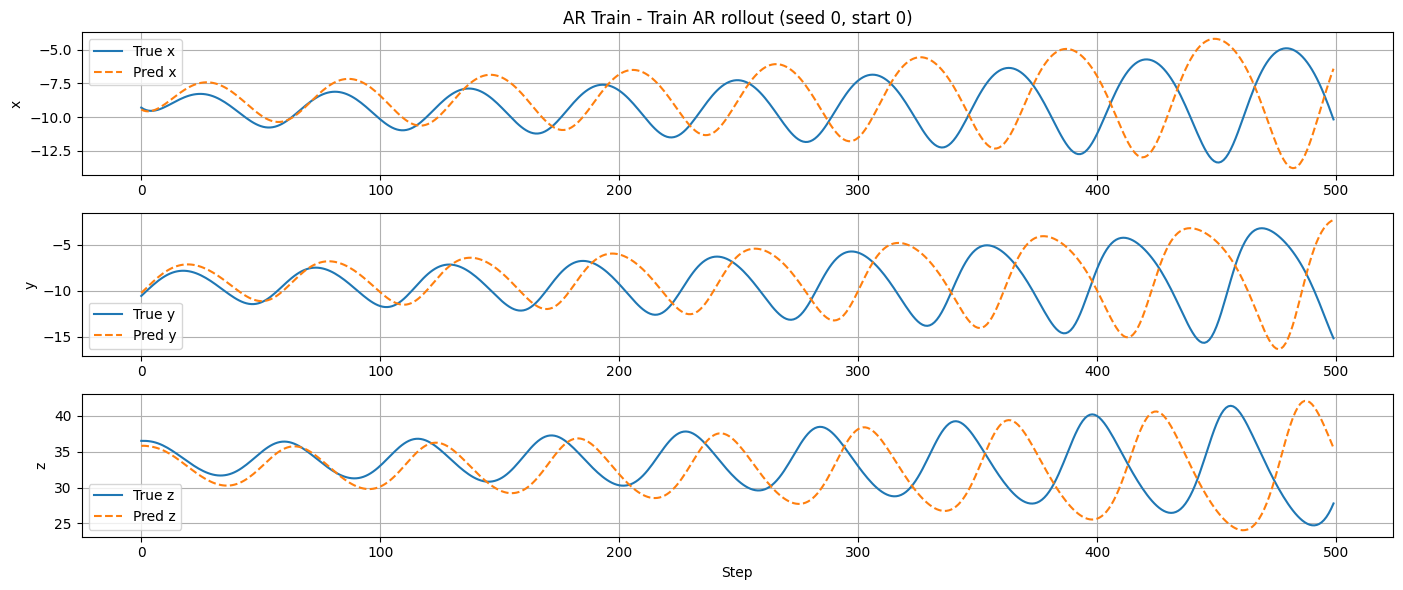

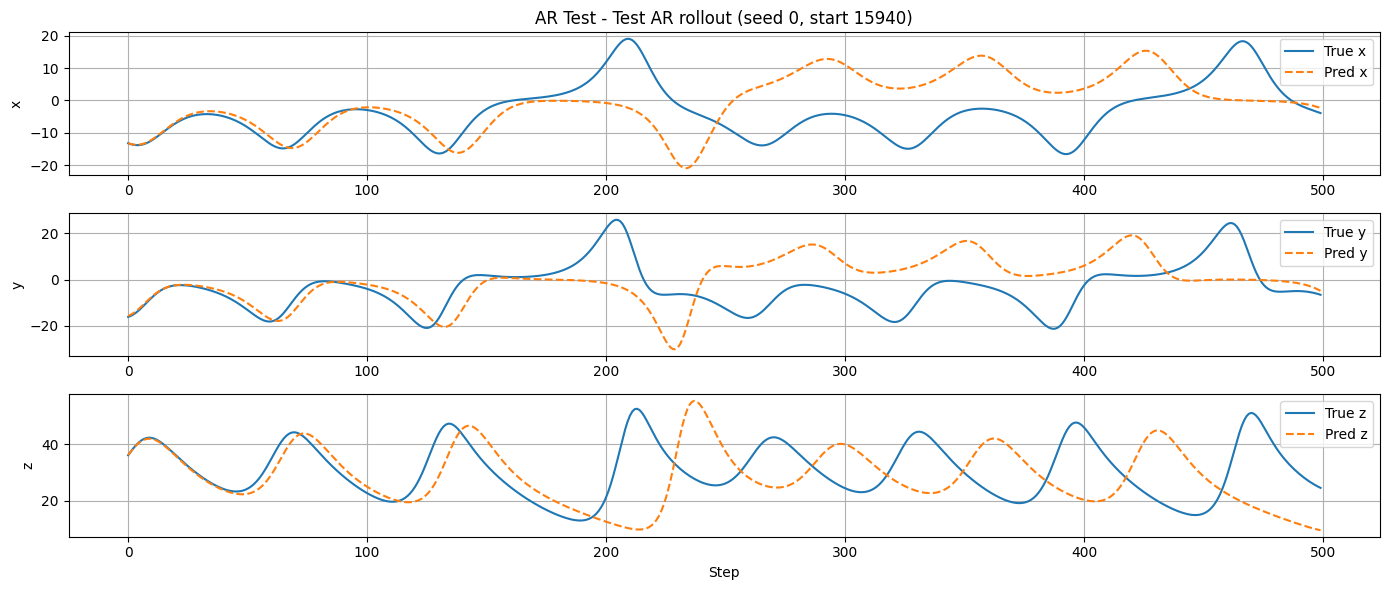

Autoregressive Test RMSE (avg over seeds, 500 steps): 12.3521
Baseline LSTM used (Chebyshev n-values not applicable).
Training RMSE (1-step, avg over dims): 0.3466
Test RMSE (1-step, avg over dims):     0.3202


In [ ]:
csv_path = 'lorenz5.csv'  # Update to your file path


hyperparameter_sets = [
    {'alpha': 0.4, 'beta': 0.6, 'n': 1, 'seq_length': 60},
    # {'alpha': -0.3, 'beta': 1.3, 'n': 1, 'seq_length': 60},
    # {'alpha': -0.5, 'beta': 0.8, 'n': 2, 'seq_length': 80},
    # {'alpha': 0.6, 'beta': 0.4, 'n': 2, 'seq_length': 80},
    # {'alpha': -0.2, 'beta': 0.9, 'n': 3, 'seq_length': 40},
    # {'alpha': 0.7, 'beta': 0.7, 'n': 3, 'seq_length': 100},
    # {'alpha': -0.1, 'beta': 0.8, 'n': 4, 'seq_length': 60},
    # {'alpha': -0.8, 'beta': 0.3, 'n': 4, 'seq_length': 80},
    # {'alpha': 0.4, 'beta': 0.6, 'n': 5, 'seq_length': 60},
    # {'alpha': -0.5, 'beta': 0.5, 'n': 5, 'seq_length': 60},
]


for dict in hyperparameter_sets:
    print('\n\n\n\n\n')
    print("Below Model uses ", dict)
    model_base, results_base, hist_base = train_from_csv(
    csv_path,
    feature_column=['x', 'y', 'z'],
    target_column=None,
    date_column='time',
    seq_length=60,
    hidden_size=64,
    epochs=5,
    use_cheby=False,          # <-- key change
   )


    df = pd.read_csv(csv_path)  # your multivariate dataset
    features = df[['x','y','z']].values   # <-- use exactly 2 features (same as training)
    init_seq = features[:dict['seq_length']]

    lyap, _, divergences = compute_lyapunov_multivariate(init_seq, model)

    print("Estimated Largest Lyapunov Exponent:", lyap)
    plt.plot(divergences)
    plt.show()


In [ ]:
print(ar_test_rmse)